In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio, display

import os
import time

import keras
import keras.layers as layers
from keras import backend as K
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


TODO
* Look into saving frames to file

* Automatic logging of graphs, errors, etc. for comparison
* Create log output function, then capture to text file (also export graphs?)


* Look for sources of noise that are close to what I want?  Or generate some clips?

* FFT variant with different bin sizes
* Debugging tools for comparing, listening to, and viewing clips
* Add audio quality comparisons between clean clips and cleaned clips for evaluation

* Add history error plotting to compare different learning models, topologies, etc.

* Why does https://towardsdatascience.com/audio-ai-isolating-vocals-from-stereo-music-using-convolutional-neural-networks-210532383785 only use real component?
* Evaluate different representations of complex numbers in terms of learnability

* Consider generating custom data for goal - male speakers, low voice, specific sounds

In [2]:
# Constants and settings
WINDOW_SIZE = 25  #Has to be odd
FFT_BINS = 1025

In [3]:
#Utilities
#def stack_fft(fft):
#    return np.stack([fft.real, fft.imag], axis=-1)

def merge_fft_img(fft_img):
    return fft_img[:,:,0] + 1j * fft_img[:,:,1]

#def unfold_target(t):
#    return np.append(t.real, [t.imag])

def combine_target(t):
    return (t[0:FFT_BINS] + 1j * t[FFT_BINS:2*FFT_BINS]).reshape((1,FFT_BINS))

def targets_to_fft(targets):
    fft = np.empty((0,FFT_BINS))
    for i in range(0, targets.shape[0]):
        fft = np.concatenate([fft,combine_target(targets[i])])
    return fft.T  # swtich to (bins, samples) since model works in (samples, bins)
    

In [4]:
# Creating data from clip wave file
# Optimization - does frames for each clip in preallocated array
# output is (samples, bins, window size, layers), where image is depth 2 for real & imaginary
def clip_frames(file):
    wav, rate = librosa.core.load(file)
    frame_lead = (WINDOW_SIZE-1)//2  # The amount before and after the target column
    fft = librosa.stft(wav) # organized as bins, frames
    pad = np.zeros((FFT_BINS,frame_lead))
    frames = np.empty(shape=(fft.shape[1],FFT_BINS,WINDOW_SIZE,2)) 
    fft = np.concatenate([pad, fft, pad], axis=-1)
    for i in range(0, fft.shape[1] - WINDOW_SIZE + 1):
        frames[i,:,:,0] = fft[:,i:i+WINDOW_SIZE].real
        frames[i,:,:,1] = fft[:,i:i+WINDOW_SIZE].imag
    return frames

# output is array (samples, double bin length made up of real then imag)
def clip_targets(file):
    wav, rate = librosa.core.load(file)
    frame_lead = (WINDOW_SIZE-1)//2  # The amount before and after the target column
    fft = librosa.stft(wav)
    targets = np.empty(shape=(fft.shape[1],2*FFT_BINS))
    for i in range(0, fft.shape[1]):
        target = fft[:,i:i+1].flatten()
        targets[i,0:FFT_BINS] = target.real
        targets[i,FFT_BINS:2*FFT_BINS] = target.imag
    return targets

In [5]:
# some test data to hack around with
test_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_010.wav"
wav, rate = librosa.core.load(test_file)
fft = librosa.stft(wav)

In [6]:
ft = clip_frames(test_file)
tt = clip_targets(test_file)

#Frame / target check
print(tt[0,1], tt[0,1026])
print( ft[0,1,5:6,0], ft[0,1,5:6,1])

# Round trip test
new_fft = targets_to_fft(tt)
new_wav = librosa.istft(new_fft)
Audio(new_wav,rate=22050)

-0.4412170350551605 -8.326672684688674e-17
[0.] [0.]


In [7]:
# Iterate over clean & noisy folders to create frames and targets
def create_data(root, max_files = 50):
    clean_dir = root + "\\Clean\\"
    noisy_dir = root + "\\Noisy\\"
    frames = np.empty(shape=(0,FFT_BINS,WINDOW_SIZE,2))
    targets = np.empty(shape=(0,2*FFT_BINS))
    i = 0
    start = time.time()
    check = time.time()
    for file in os.listdir(clean_dir)[0:max_files]:
        i += 1
        if i % 50 == 0:
            print("{0} clips   total {1:.0f}   last cycle {2:.0f}".format(i, time.time() - start,time.time()-check))
            check = time.time()
        filename = os.fsdecode(file)
        frames = np.concatenate((frames,clip_frames(noisy_dir + file)), axis=0)
        targets = np.concatenate((targets,clip_targets(clean_dir + file)), axis=0)
    return frames, targets


In [8]:
frames, targets = create_data("Assets\\DataShareArchive\\Test", 100)

50 clips   total 43   last cycle 43
100 clips   total 111   last cycle 68


In [9]:
# Real model (eventually)

inputs = layers.Input(shape=(FFT_BINS,WINDOW_SIZE,2)) # Full window
input_slice = layers.Input(shape=(FFT_BINS,1,2)) # Just the center row that we're trying to predict
conv1 = layers.Conv2D(32, kernel_size=(5,3), activation='relu', padding='valid', 
                      input_shape=[FFT_BINS,WINDOW_SIZE,2])(inputs)
conv2 = layers.Conv2D(32, kernel_size=(5,3), activation='relu')(conv1) 
pool1 = layers.MaxPooling2D(pool_size=(3,3))(conv2)
conv3 = layers.Conv2D(32, kernel_size=(5,3), activation='relu')(pool1) 
pool2 = layers.MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = layers.Conv2D(16, kernel_size=1, activation='relu')(pool2) # Seems like making this too big causes OOM
flat = layers.Flatten()(conv4)
dense0 = layers.Dense(1500, activation='relu')(flat)
dense1 = layers.Dense(1500, activation='relu')(dense0)
dense2 = layers.Dense(500, activation='relu')(dense1)
flat_in = layers.Flatten()(input_slice)
merged = layers.concatenate([dense2, flat_in])
outputs = layers.Dense(2*FFT_BINS, activation='linear')(merged)

model = keras.models.Model(inputs=[inputs,input_slice], outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

print(model.summary())






__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1025, 25, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1021, 23, 32) 992         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1017, 21, 32) 15392       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 339, 7, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2

In [10]:
hist = model.fit([frames, frames[:,:,5:6,:]], targets, epochs=25, batch_size=32, validation_split=0.05)




Train on 11944 samples, validate on 629 samples
Epoch 1/25





11944/11944 [==============================] - 56s 5ms/step - loss: 2.4555 - val_loss: 2.2775
Epoch 2/25
11944/11944 [==============================] - 48s 4ms/step - loss: 2.1797 - val_loss: 2.2842
Epoch 3/25
11944/11944 [==============================] - 47s 4ms/step - loss: 2.1461 - val_loss: 2.3118
Epoch 4/25
11944/11944 [==============================] - 48s 4ms/step - loss: 2.1379 - val_loss: 2.3387
Epoch 5/25
11944/11944 [==============================] - 48s 4ms/step - loss: 2.1238 - val_loss: 2.3499
Epoch 6/25
11944/11944 [==============================] - 48s 4ms/step - loss: 2.1010 - val_loss: 2.3664
Epoch 7/25
11944/11944 [==============================] - 48s 4ms/step - loss: 2.0992 - val_loss: 2.3840
Epoch 8/25
11944/11944 [==============================] - 48s 4ms/step - loss: 2.0890 - val_loss: 2.3835
Epoch 9/25
11944/11944 [==============================] - 49s 4ms/step - loss: 2.0583 - val_loss: 2.4155

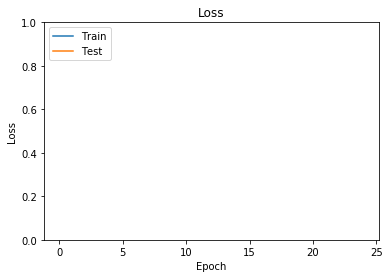

Validation loss mean 5+ epochs 2.443
Clips  12573


In [11]:

history = hist

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim((0, 1)) 
plt.show()

#plt.savefig('test.png')
print("Validation loss mean 5+ epochs {0:.4}".format(np.mean(history.history['val_loss'][5:])))
print("Clips ", frames.shape[0])

#Add verification means for 1-10, 11-20, 21-30?  Or slope for different ranges?

In [30]:
#%%capture cap
print(model.summary())
#with open('output.txt', 'w') as f:
#    f.write(cap.stdout)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1025, 11, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 10, 8)  72          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 512, 5, 8)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 20480)        0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
dense_1 (D

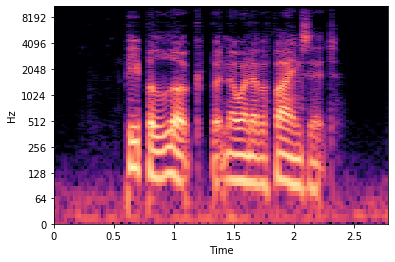

In [14]:
# Full round trip test

verify_file = "Assets\\DataShareArchive\\Test\\Noisy\\p232_019.wav"
verify_frames = clip_frames(verify_file)
verify_targets = clip_targets(verify_file)

output_targets = model.predict([verify_frames, verify_frames[:,:,5:6,:]])

p_fft = targets_to_fft(output_targets)
#p_fft = targets_to_fft(verify_targets)

def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='log', x_axis='time')

display_fft(p_fft)
p_wav = librosa.istft(p_fft)
Audio(p_wav,rate=22050)


In [16]:
fresh_wav, rate = librosa.core.load("Assets\\DataShareArchive\\Test\\Noisy\\p232_019.wav")
Audio(fresh_wav, rate=rate)

Test & reference stuff 

(1025, 120)


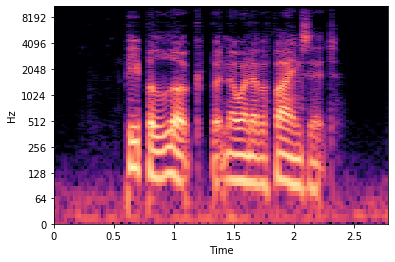

In [114]:
    
def show_fft(wav):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max), y_axis='log', x_axis='time')

def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='log', x_axis='time')

librosa.display.specshow(librosa.amplitude_to_db(np.abs(new_fft), ref=np.max), y_axis='log', x_axis='time')

print(new_fft.shape)

#show_fft(wav)
#show_fft(new_wav)
#Audio(wav, rate=22050)


In [37]:
# Test stuff for hacking around    
    
a = np.array([[1+2j, 3+4j, 1.5+2.5j],[5+6j,7+8j, 5.5+6.5j]])
print(a)
a1 = a[0]
print(a1)
ar = a1.real
ai = a1.imag

st = np.zeros((6))
st[0:3] = ar
st[3:6] = ai
print(ar.shape, ai.shape, st.shape)
print(ar, ai)
print(st)


[[1. +2.j  3. +4.j  1.5+2.5j]
 [5. +6.j  7. +8.j  5.5+6.5j]]
[1. +2.j  3. +4.j  1.5+2.5j]
(3,) (3,) (6,)
[1.  3.  1.5] [2.  4.  2.5]
[1.  3.  1.5 2.  4.  2.5]
1


In [118]:
# ''do nothing' model that should be able to guess outputs from outputs

inputs = layers.Input(shape=(FFT_BINS*2,))
dense1 = layers.Dense(2000, activation='relu')(inputs)
dense2 = layers.Dense(2000, activation='relu')(dense1)
#flat = layers.Flatten()(dense)
#flat_in = layers.Flatten()(inputs)
#merged = layers.concatenate([flat, flat_in])
merged = layers.concatenate([dense2, inputs])
linear = layers.Dense(2000, activation='linear')(merged)
outputs = layers.Dense(2*FFT_BINS, activation='linear')(linear)

model = keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

model.fit(targets, targets, epochs=1, batch_size=32)

Epoch 1/1
7537/7537 [==============================] - 46s 6ms/step - loss: 0.5679
